# Préparez des données pour un organisme de santé publique

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Étape 1 : Nettoyez et filtrez des features et produits 

Je met le chargement du csv en commentaire pour éviter de le recharger à chaque fois que je lance le code. Si vous voyez ceci c'est que j'ai oublié de l'enlever.

In [72]:
# df = pd.read_csv("fr.openfoodfacts.org.products.csv", sep="\t", low_memory=False)

# df_backup = df
# df.head()

In [73]:
df = df_backup

Commençons par analyser un petit peu les données.

In [74]:
df.shape

(320772, 162)

In [75]:
df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'ph_100g', 'fruits-vegetables-nuts_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=162)

Nous allons séléctioner une variable ayant entre 50% et 80% de valeurs manquantes. Ce sera notre variable à analyser.

In [76]:
missing_values = df.isnull().mean()

missing_values.loc[missing_values > 0.5].loc[missing_values < 0.8].sort_values()

additives_tags      0.517788
additives_fr        0.517788
cholesterol_100g    0.550802
trans-fat_100g      0.553271
calcium_100g        0.560280
vitamin-c_100g      0.560850
iron_100g           0.562113
vitamin-a_100g      0.571178
quantity            0.673229
pnns_groups_2       0.705426
pnns_groups_1       0.714710
categories_fr       0.736850
categories          0.736854
categories_tags     0.736919
main_category_fr    0.736991
main_category       0.736991
packaging_tags      0.753841
packaging           0.753844
image_url           0.763583
image_small_url     0.763583
dtype: float64

La variable "main_category" paraît parfaite. C'est une variable catégorielle et elle est ni trop vide ni trop remplis.

In [77]:
target = df["main_category"]

Maintenant, visualisons les données en fonctions du pourcentage de valuers manquantes.

Text(0.5, 1.0, 'Pourcentage de valeurs manquantes pour chaque variable')

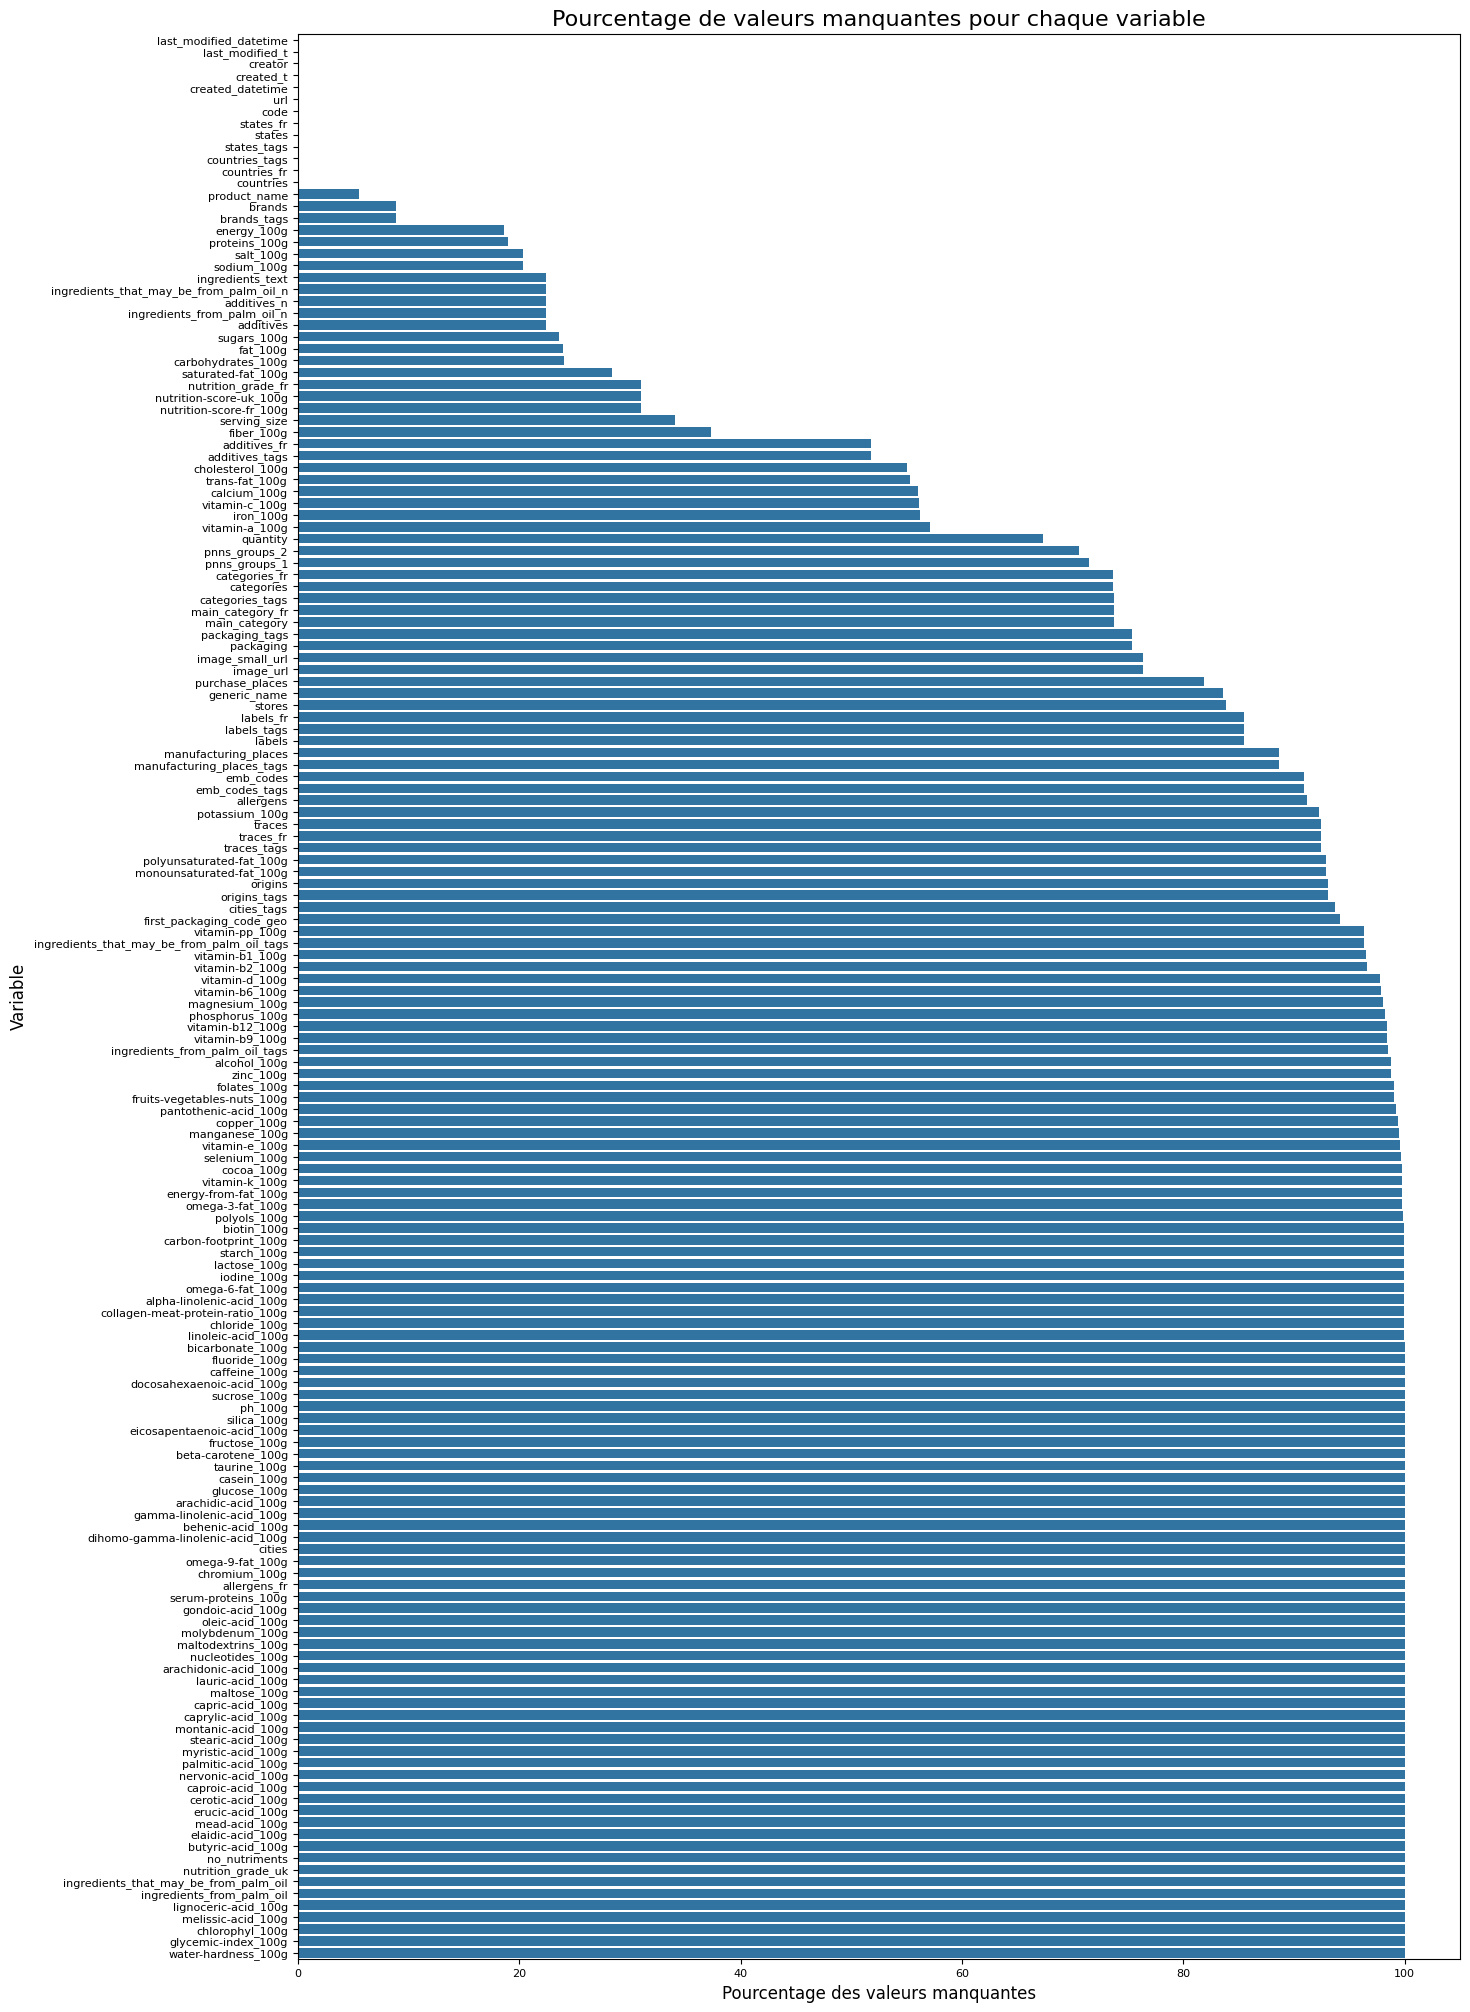

In [78]:
proportion_of_emptiness = df.isnull().mean() * 100
proportion_of_emptiness = pd.DataFrame(proportion_of_emptiness).reset_index().sort_values(0)

fig = plt.figure(figsize=(15, 25))

plt.rcParams.update({"font.size": 8})
sns.barplot(data=proportion_of_emptiness, x=0, y="index")
plt.xlabel("Pourcentage des valeurs manquantes", fontsize=12)
plt.ylabel("Variable", fontsize=12)
plt.title("Pourcentage de valeurs manquantes pour chaque variable", fontsize=16)

Supprimons les variables comportants moins de 50% de taux de remplissage.

In [79]:
df = df.loc[:, missing_values < 0.5]

Utilisons l'URL des produits pour supprimer les doublons.

In [80]:
duplicated_rows = df["url"].duplicated()
duplicated_rows.sum()

np.int64(22)

In [81]:
df = df.loc[duplicated_rows == False]
df.duplicated().sum()

np.int64(0)

Nous allons maintenant faire la séléction des variables qui seront destinées à prédire la variable cible.

In [82]:
df = df[[
    "brands",
    "ingredients_text",
    "nutrition_grade_fr",
    "energy_100g",
    "fat_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g",
    "nutrition-score-fr_100g"
]]

In [83]:
def features_selection(dataframe):
    dataframe.columns
    target = dataframe["main_category"]
    df.isnull().mean()
    dataframe = dataframe.loc[df["code"].duplicated() == False]
    dataframe = dataframe[[
        "brands",
        "ingredients_text",
        "nutrition_grade_fr",
        "energy_100g",
        "fat_100g",
        "sugars_100g",
        "fiber_100g",
        "proteins_100g",
        "salt_100g",
        "nutrition-score-fr_100g"
    ]]
    return (dataframe, target)

## Étape 2 : Identifiez et traitez les valeurs aberrantes

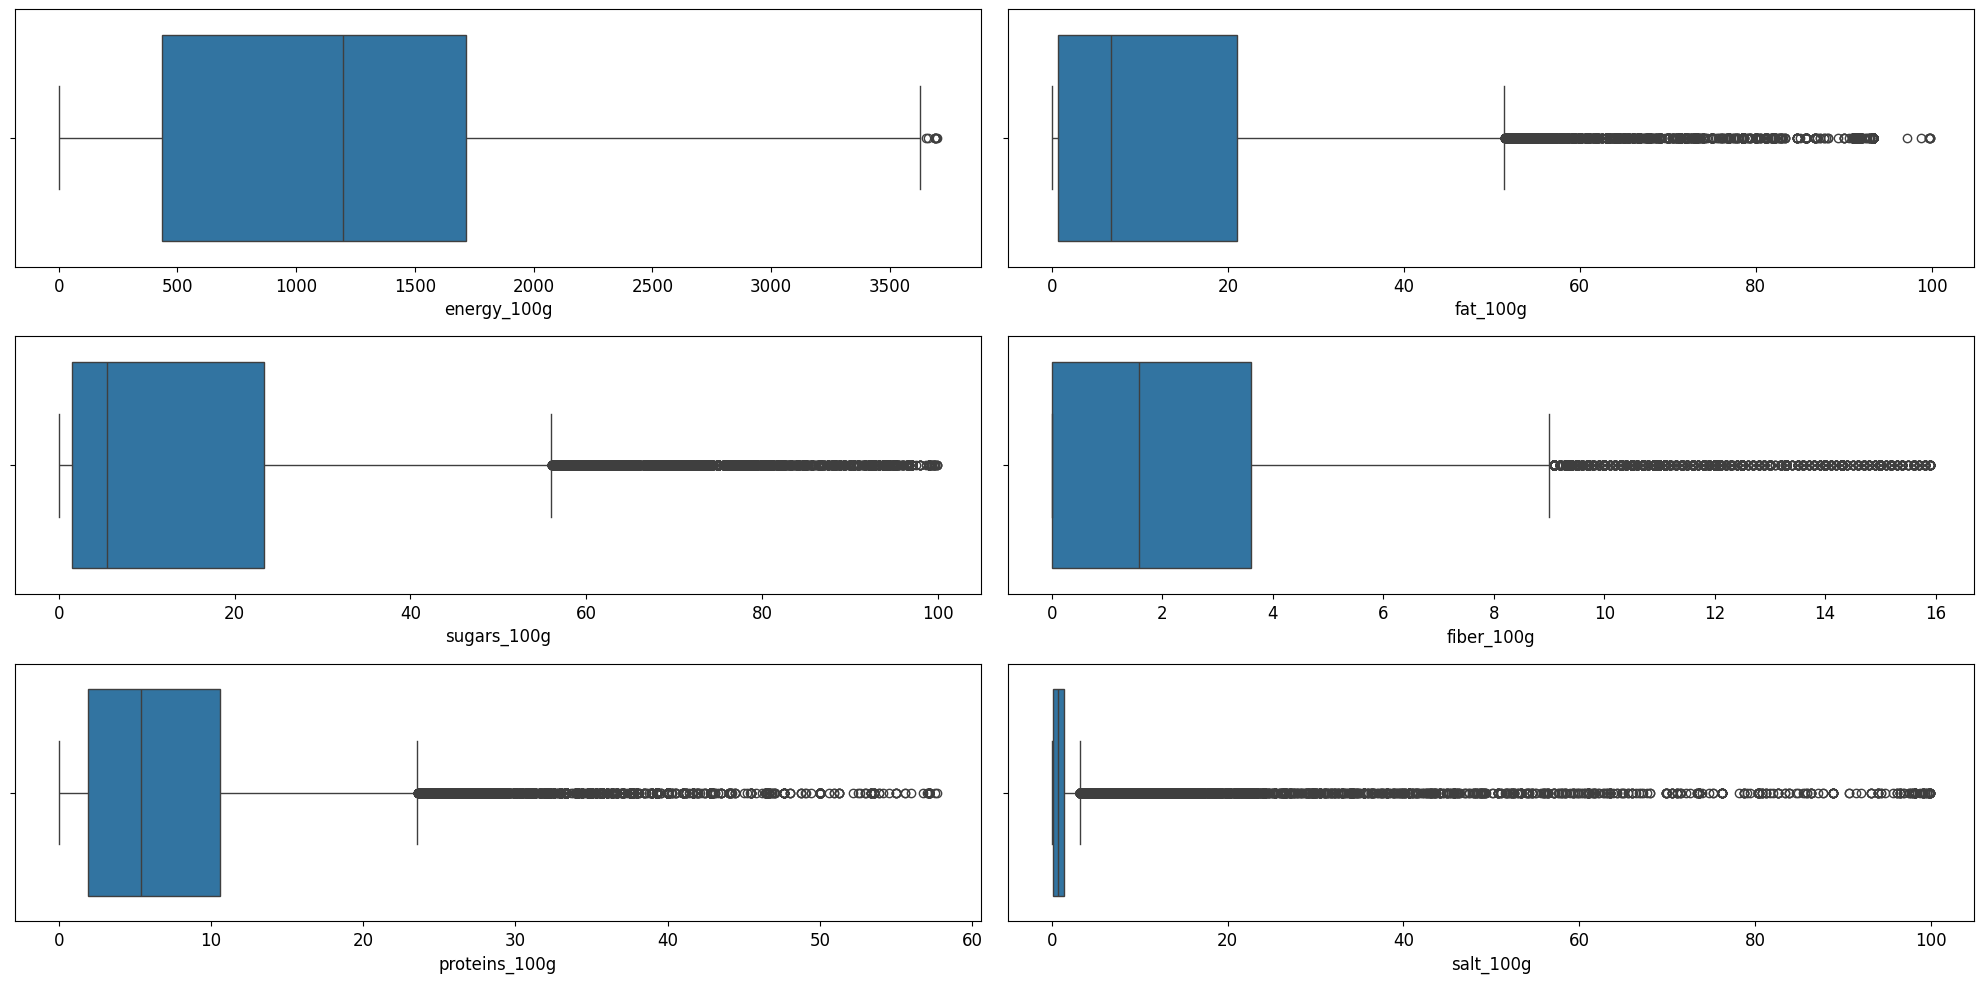

In [104]:
nutritive_values = ["energy_100g", "fat_100g", "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g"]

plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(3, 2, figsize=(20,10))

ax = ax.flatten()
for i, value in enumerate(nutritive_values[0:len(nutritive_values)]):
    sns.boxplot(data=df, x=value, ax=ax[i])

plt.tight_layout()

In [85]:
df = df.loc[df["energy_100g"] >= 0].loc[df["energy_100g"] < 3700]
df = df.loc[df["fat_100g"] >= 0].loc[df["fat_100g"] < 100]
df = df.loc[df["sugars_100g"] >= 0].loc[df["sugars_100g"] < 100]
df = df.loc[df["fiber_100g"] >= 0].loc[df["fiber_100g"] < 16]
df = df.loc[df["proteins_100g"] >= 0].loc[df["proteins_100g"] < 58]
df = df.loc[df["salt_100g"] >= 0].loc[df["salt_100g"] < 100]

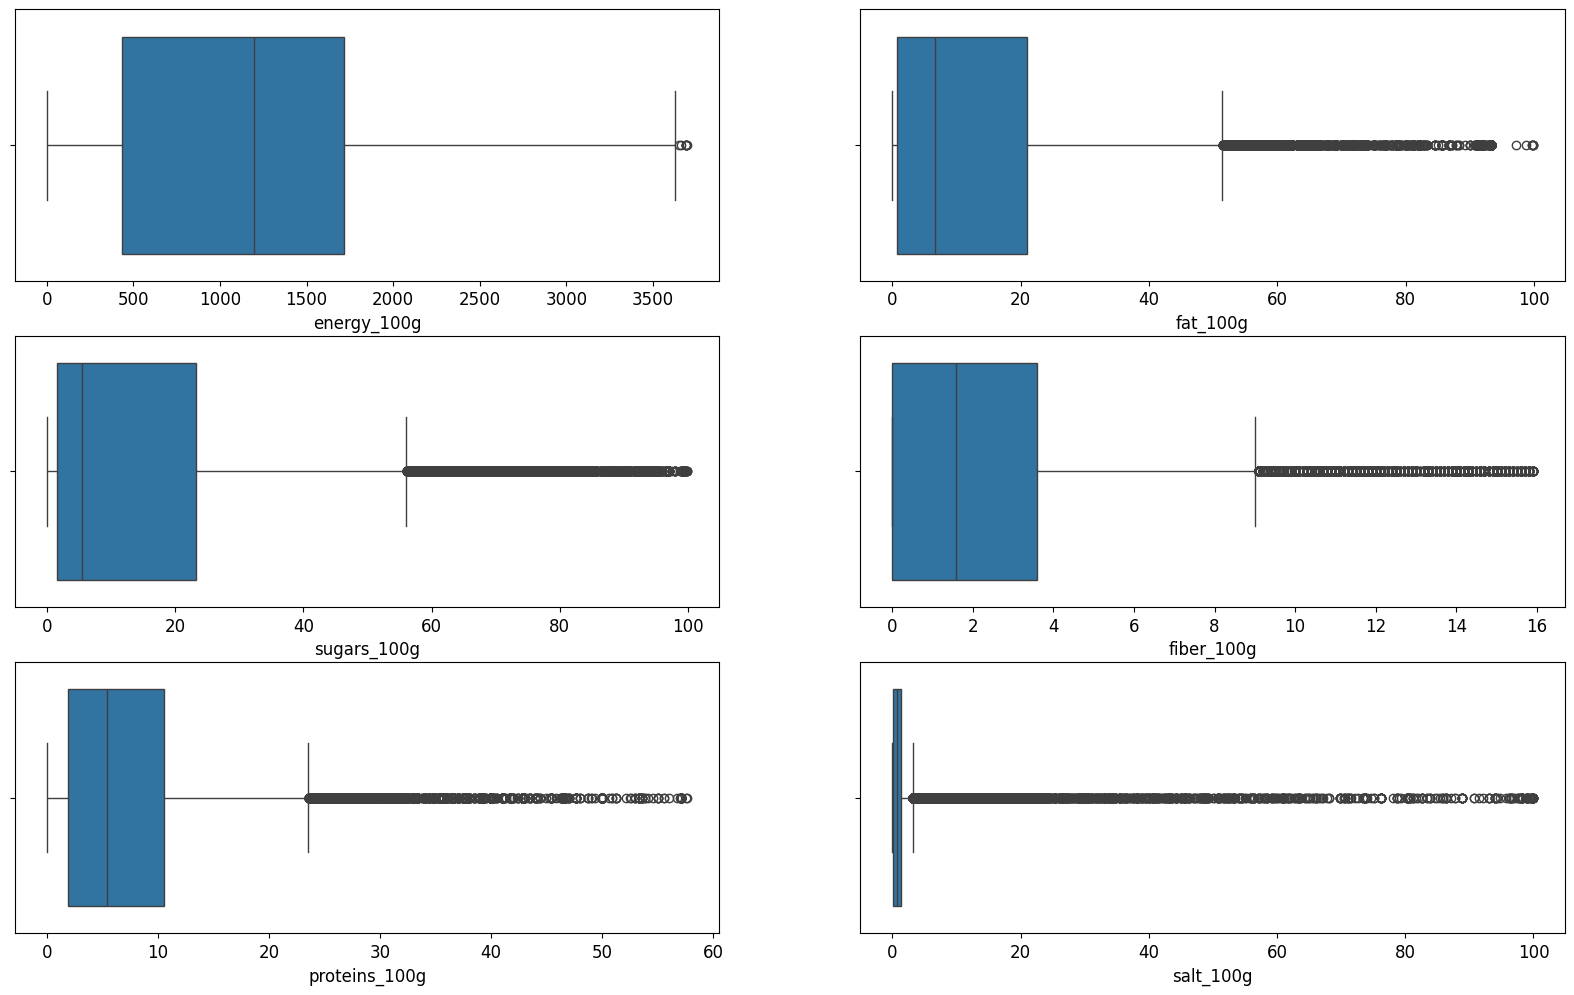

In [86]:
fig, ax = plt.subplots(4, 2, figsize=(20,12))

ax = ax.flatten()

for i, value in enumerate(nutritive_values[0:len(nutritive_values)]):
    sns.boxplot(data=df, x=value, ax=ax[i])

<Axes: xlabel='nutrition_grade_fr', ylabel='Count'>

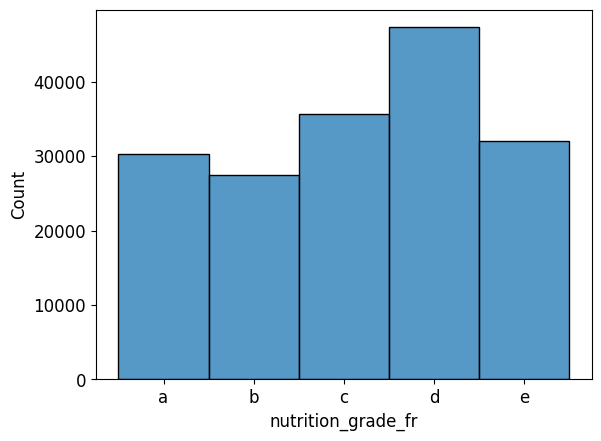

In [130]:
df['nutrition_grade_fr'] = pd.Categorical(df['nutrition_grade_fr'], ["a","b","c","d","e"])
sns.histplot(data=df["nutrition_grade_fr"])

In [87]:
iqr_scores = []

for value in nutritive_values:
    iqr = np.quantile(df[value], q=[0.25, 0.75])
    iqr_scores.append((iqr[1] + 1.5*(iqr[1] - iqr[0])))

iqr_scores_df = pd.DataFrame(iqr_scores)
iqr_scores_df.index = nutritive_values
iqr_scores_df.rename(columns={0:"IQR scores"}, inplace=True)
iqr_scores_df

TypeError: '<' not supported between instances of 'str' and 'float'

<Axes: xlabel='nutrition-score-fr_100g'>

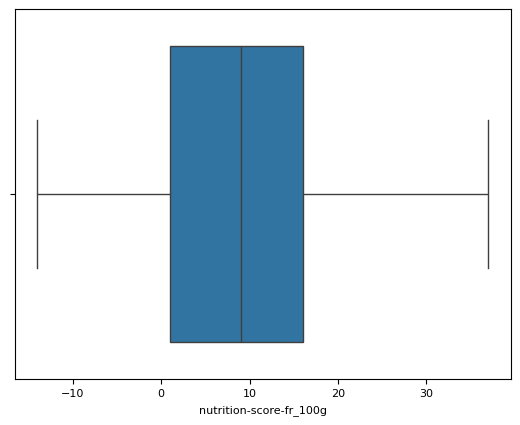

In [38]:
sns.boxplot(data=df, x="nutrition-score-fr_100g")